In [ ]:
pip install -U scikit-learn 

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7')

import re
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold, StratifiedKFold , GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.manifold import TSNE
import seaborn as sns

import lightgbm as lgb

import pickle

import sklearn


import joblib

In [2]:
from My_Fonctions.fonctions import *

In [3]:
data = "/content/drive/MyDrive/Openclassrooms/P7 scoring/data/"

## pre processing du data set

Fonction réalisé à partir du kernel Kaggle : https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

In [ ]:
df_data_load = preproc(data,num_row=None)

Train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 20s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 27s


In [ ]:
df_data_load = df_data_load.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Sauvegarde du data set

In [ ]:
df_data_load.shape

(356251, 542)

In [ ]:
df_data_load['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [ ]:
df_data_load['TARGET'].isna().sum() 

48744

In [ ]:
df_data_load.head(5)

,index,SKIDCURR,TARGET,CODEGENDER,FLAGOWNCAR,FLAGOWNREALTY,CNTCHILDREN,AMTINCOMETOTAL,AMTCREDIT,AMTANNUITY,AMTGOODSPRICE,REGIONPOPULATIONRELATIVE,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,CNTFAMMEMBERS,REGIONRATINGCLIENT,REGIONRATINGCLIENTWCITY,HOURAPPRPROCESSSTART,REGREGIONNOTLIVEREGION,REGREGIONNOTWORKREGION,LIVEREGIONNOTWORKREGION,REGCITYNOTLIVECITY,REGCITYNOTWORKCITY,LIVECITYNOTWORKCITY,EXTSOURCE1,EXTSOURCE2,EXTSOURCE3,OBS30CNTSOCIALCIRCLE,DEF30CNTSOCIALCIRCLE,OBS60CNTSOCIALCIRCLE,DEF60CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,FLAGDOCUMENT3,FLAGDOCUMENT5,FLAGDOCUMENT6,FLAGDOCUMENT7,FLAGDOCUMENT8,FLAGDOCUMENT9,...,APPROVEDHOURAPPRPROCESSSTARTMAX,APPROVEDHOURAPPRPROCESSSTARTMEAN,APPROVEDRATEDOWNPAYMENTMIN,APPROVEDRATEDOWNPAYMENTMAX,APPROVEDRATEDOWNPAYMENTMEAN,APPROVEDDAYSDECISIONMIN,APPROVEDDAYSDECISIONMAX,APPROVEDDAYSDECISIONMEAN,APPROVEDCNTPAYMENTMEAN,APPROVEDCNTPAYMENTSUM,REFUSEDAMTANNUITYMIN,REFUSEDAMTANNUITYMAX,REFUSEDAMTANNUITYMEAN,REFUSEDAMTAPPLICATIONMIN,REFUSEDAMTAPPLICATIONMAX,REFUSEDAMTAPPLICATIONMEAN,REFUSEDAMTCREDITMIN,REFUSEDAMTCREDITMAX,REFUSEDAMTCREDITMEAN,REFUSEDAPPCREDITPERCMIN,REFUSEDAPPCREDITPERCMAX,REFUSEDAPPCREDITPERCMEAN,REFUSEDAPPCREDITPERCVAR,REFUSEDAMTDOWNPAYMENTMIN,REFUSEDAMTDOWNPAYMENTMAX,REFUSEDAMTDOWNPAYMENTMEAN,REFUSEDAMTGOODSPRICEMIN,REFUSEDAMTGOODSPRICEMAX,REFUSEDAMTGOODSPRICEMEAN,REFUSEDHOURAPPRPROCESSSTARTMIN,REFUSEDHOURAPPRPROCESSSTARTMAX,REFUSEDHOURAPPRPROCESSSTARTMEAN,REFUSEDRATEDOWNPAYMENTMIN,REFUSEDRATEDOWNPAYMENTMAX,REFUSEDRATEDOWNPAYMENTMEAN,REFUSEDDAYSDECISIONMIN,REFUSEDDAYSDECISIONMAX,REFUSEDDAYSDECISIONMEAN,REFUSEDCNTPAYMENTMEAN,REFUSEDCNTPAYMENTSUM
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,1,0,0,0,0,0,...,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.000000,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,1,0,0,0,0,0,...,17.0,14.666667,0.000000,0.100061,0.050030,-2341.0,-746.0,-1305.000000,10.000000,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,...,5.0,5.000000,0.212008,0.212008,0.212008,-815.0,-815.0,-815.000000,4.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,1,0,0,0,0,0,...,15.0,14.400000,0.108994,0.217830,0.163412,-617.0,-181.0,-345.600000,18.000000,90.0,32696.1,32696.1,32696.1,688500.0,688500.0,688500.0,906615.0,906615.0,906615.0,0.759418,0.759418,0.759418,NaN,NaN,NaN,NaN,688500.0,688500.0,688500.0,15.0,15.0,15.0,NaN,NaN,NaN,-181.0,-181.0,-181.0,48.0,48.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,1,0,...,15.0,12.333333,0.100143,0.218890,0.159516,-2357.0,-374.0,-1222.833333,20.666667,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
joblib.dump(df_data_load, data + 'df_data_load.joblib')

['/content/drive/MyDrive/Openclassrooms/P7 scoring/data/df_data_load.joblib']

Création d'un mini dataset test pour le dash board

In [ ]:
df_data_load_test =  df_data_load[df_data_load["TARGET"].isnull() ]

In [ ]:
df_data_load_test_light = resample(df_data_load_test, n_samples=5000)

In [ ]:
joblib.dump(df_data_load_test_light, "/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/df_data_dash.joblib")

['/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/df_data_dash.joblib']

# restauration du dataset

In [ ]:
df_data = joblib.load(data + 'df_data_load.joblib')

In [4]:
df_data_light = joblib.load('/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/df_data_dash.joblib')

In [5]:
df_data_light.to_pickle("/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/df_data_dash.pkl")

supression des colonnes non necessaires

In [ ]:
df_data.head(5)

,index,SKIDCURR,TARGET,CODEGENDER,FLAGOWNCAR,FLAGOWNREALTY,CNTCHILDREN,AMTINCOMETOTAL,AMTCREDIT,AMTANNUITY,AMTGOODSPRICE,REGIONPOPULATIONRELATIVE,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,CNTFAMMEMBERS,REGIONRATINGCLIENT,REGIONRATINGCLIENTWCITY,HOURAPPRPROCESSSTART,REGREGIONNOTLIVEREGION,REGREGIONNOTWORKREGION,LIVEREGIONNOTWORKREGION,REGCITYNOTLIVECITY,REGCITYNOTWORKCITY,LIVECITYNOTWORKCITY,EXTSOURCE1,EXTSOURCE2,EXTSOURCE3,OBS30CNTSOCIALCIRCLE,DEF30CNTSOCIALCIRCLE,OBS60CNTSOCIALCIRCLE,DEF60CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,FLAGDOCUMENT3,FLAGDOCUMENT5,FLAGDOCUMENT6,FLAGDOCUMENT7,FLAGDOCUMENT8,FLAGDOCUMENT9,...,APPROVEDHOURAPPRPROCESSSTARTMAX,APPROVEDHOURAPPRPROCESSSTARTMEAN,APPROVEDRATEDOWNPAYMENTMIN,APPROVEDRATEDOWNPAYMENTMAX,APPROVEDRATEDOWNPAYMENTMEAN,APPROVEDDAYSDECISIONMIN,APPROVEDDAYSDECISIONMAX,APPROVEDDAYSDECISIONMEAN,APPROVEDCNTPAYMENTMEAN,APPROVEDCNTPAYMENTSUM,REFUSEDAMTANNUITYMIN,REFUSEDAMTANNUITYMAX,REFUSEDAMTANNUITYMEAN,REFUSEDAMTAPPLICATIONMIN,REFUSEDAMTAPPLICATIONMAX,REFUSEDAMTAPPLICATIONMEAN,REFUSEDAMTCREDITMIN,REFUSEDAMTCREDITMAX,REFUSEDAMTCREDITMEAN,REFUSEDAPPCREDITPERCMIN,REFUSEDAPPCREDITPERCMAX,REFUSEDAPPCREDITPERCMEAN,REFUSEDAPPCREDITPERCVAR,REFUSEDAMTDOWNPAYMENTMIN,REFUSEDAMTDOWNPAYMENTMAX,REFUSEDAMTDOWNPAYMENTMEAN,REFUSEDAMTGOODSPRICEMIN,REFUSEDAMTGOODSPRICEMAX,REFUSEDAMTGOODSPRICEMEAN,REFUSEDHOURAPPRPROCESSSTARTMIN,REFUSEDHOURAPPRPROCESSSTARTMAX,REFUSEDHOURAPPRPROCESSSTARTMEAN,REFUSEDRATEDOWNPAYMENTMIN,REFUSEDRATEDOWNPAYMENTMAX,REFUSEDRATEDOWNPAYMENTMEAN,REFUSEDDAYSDECISIONMIN,REFUSEDDAYSDECISIONMAX,REFUSEDDAYSDECISIONMEAN,REFUSEDCNTPAYMENTMEAN,REFUSEDCNTPAYMENTSUM
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,1,0,0,0,0,0,...,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.000000,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,1,0,0,0,0,0,...,17.0,14.666667,0.000000,0.100061,0.050030,-2341.0,-746.0,-1305.000000,10.000000,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,...,5.0,5.000000,0.212008,0.212008,0.212008,-815.0,-815.0,-815.000000,4.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,1,0,0,0,0,0,...,15.0,14.400000,0.108994,0.217830,0.163412,-617.0,-181.0,-345.600000,18.000000,90.0,32696.1,32696.1,32696.1,688500.0,688500.0,688500.0,906615.0,906615.0,906615.0,0.759418,0.759418,0.759418,NaN,NaN,NaN,NaN,688500.0,688500.0,688500.0,15.0,15.0,15.0,NaN,NaN,NaN,-181.0,-181.0,-181.0,48.0,48.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,1,0,...,15.0,12.333333,0.100143,0.218890,0.159516,-2357.0,-374.0,-1222.833333,20.666667,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_data_light = joblib.load('/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/df_data_dash.joblib')

In [ ]:
df_data_light.head(5)

,index,SKIDCURR,TARGET,CODEGENDER,FLAGOWNCAR,FLAGOWNREALTY,CNTCHILDREN,AMTINCOMETOTAL,AMTCREDIT,AMTANNUITY,AMTGOODSPRICE,REGIONPOPULATIONRELATIVE,DAYSBIRTH,DAYSEMPLOYED,DAYSREGISTRATION,DAYSIDPUBLISH,CNTFAMMEMBERS,REGIONRATINGCLIENT,REGIONRATINGCLIENTWCITY,HOURAPPRPROCESSSTART,REGREGIONNOTLIVEREGION,REGREGIONNOTWORKREGION,LIVEREGIONNOTWORKREGION,REGCITYNOTLIVECITY,REGCITYNOTWORKCITY,LIVECITYNOTWORKCITY,EXTSOURCE1,EXTSOURCE2,EXTSOURCE3,OBS30CNTSOCIALCIRCLE,DEF30CNTSOCIALCIRCLE,OBS60CNTSOCIALCIRCLE,DEF60CNTSOCIALCIRCLE,DAYSLASTPHONECHANGE,FLAGDOCUMENT3,FLAGDOCUMENT5,FLAGDOCUMENT6,FLAGDOCUMENT7,FLAGDOCUMENT8,FLAGDOCUMENT9,...,APPROVEDHOURAPPRPROCESSSTARTMAX,APPROVEDHOURAPPRPROCESSSTARTMEAN,APPROVEDRATEDOWNPAYMENTMIN,APPROVEDRATEDOWNPAYMENTMAX,APPROVEDRATEDOWNPAYMENTMEAN,APPROVEDDAYSDECISIONMIN,APPROVEDDAYSDECISIONMAX,APPROVEDDAYSDECISIONMEAN,APPROVEDCNTPAYMENTMEAN,APPROVEDCNTPAYMENTSUM,REFUSEDAMTANNUITYMIN,REFUSEDAMTANNUITYMAX,REFUSEDAMTANNUITYMEAN,REFUSEDAMTAPPLICATIONMIN,REFUSEDAMTAPPLICATIONMAX,REFUSEDAMTAPPLICATIONMEAN,REFUSEDAMTCREDITMIN,REFUSEDAMTCREDITMAX,REFUSEDAMTCREDITMEAN,REFUSEDAPPCREDITPERCMIN,REFUSEDAPPCREDITPERCMAX,REFUSEDAPPCREDITPERCMEAN,REFUSEDAPPCREDITPERCVAR,REFUSEDAMTDOWNPAYMENTMIN,REFUSEDAMTDOWNPAYMENTMAX,REFUSEDAMTDOWNPAYMENTMEAN,REFUSEDAMTGOODSPRICEMIN,REFUSEDAMTGOODSPRICEMAX,REFUSEDAMTGOODSPRICEMEAN,REFUSEDHOURAPPRPROCESSSTARTMIN,REFUSEDHOURAPPRPROCESSSTARTMAX,REFUSEDHOURAPPRPROCESSSTARTMEAN,REFUSEDRATEDOWNPAYMENTMIN,REFUSEDRATEDOWNPAYMENTMAX,REFUSEDRATEDOWNPAYMENTMEAN,REFUSEDDAYSDECISIONMIN,REFUSEDDAYSDECISIONMAX,REFUSEDDAYSDECISIONMEAN,REFUSEDCNTPAYMENTMEAN,REFUSEDCNTPAYMENTSUM
349616,42105,407942,NaN,0,0,0,1,180000.0,513040.5,53874.0,472500.0,0.072508,-13551,-2446.0,-6315.0,-4715,3.0,1,1,10,0,0,0,0,0,0,NaN,0.704475,NaN,0.0,0.0,0.0,0.0,-1992.0,1,0,0,0,0,0,...,18.0,14.666667,0.108921,0.108921,0.108921,-1992.0,-355.0,-900.666667,8.000000,24.0,16016.40,17196.795,16606.5975,160182.0,160182.0,160182.0,144162.0,154786.5,149474.25,1.034858,1.111125,1.072991,0.002908,16020.0,16020.0,16020.0,160182.0,160182.0,160182.0,18.0,18.0,18.0,0.102146,0.108921,0.105534,-1992.0,-1992.0,-1992.0,10.0,20.0
343160,35649,360872,NaN,0,1,0,0,202500.0,278460.0,22455.0,225000.0,0.019689,-11217,-2441.0,-5312.0,-3105,1.0,2,2,16,0,0,0,0,0,0,0.269598,0.560577,0.211551,0.0,0.0,0.0,0.0,-603.0,0,0,0,0,0,1,...,14.0,12.500000,0.000000,0.000000,0.000000,-603.0,-235.0,-419.000000,8.000000,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310675,3164,122207,NaN,1,0,0,0,157500.0,1570797.0,64953.0,1404000.0,0.046220,-15387,-801.0,-6153.0,-5829,2.0,1,1,12,0,1,1,0,0,0,0.835349,0.702344,0.508287,0.0,0.0,0.0,0.0,-230.0,1,0,0,0,0,0,...,17.0,12.571429,0.000000,0.000000,0.000000,-2239.0,-272.0,-1153.857143,11.142857,78.0,23007.51,23007.510,23007.5100,157500.0,157500.0,157500.0,192762.0,192762.0,192762.00,0.817070,0.817070,0.817070,NaN,NaN,NaN,NaN,157500.0,157500.0,157500.0,10.0,10.0,10.0,NaN,NaN,NaN,-660.0,-660.0,-660.0,12.0,12.0
315022,7511,155014,NaN,0,1,0,0,225000.0,225000.0,17410.5,225000.0,0.072508,-12800,-751.0,-1707.0,-956,2.0,1,1,14,0,0,0,0,0,0,0.631605,0.662244,0.492060,0.0,0.0,0.0,0.0,-554.0,0,0,0,0,1,0,...,19.0,15.000000,0.000000,0.108912,0.054456,-554.0,-291.0,-422.500000,10.000000,20.0,2250.00,12768.345,7509.1725,45000.0,65178.0,55089.0,45000.0,69048.0,57024.00,0.943952,1.000000,0.971976,0.001571,0.0,0.0,0.0,45000.0,65178.0,55089.0,17.0,19.0,18.0,0.000000,0.000000,0.000000,-309.0,-291.0,-300.0,3.0,6.0
317095,9584,169677,NaN,1,0,0,0,211500.0,630000.0,40392.0,630000.0,0.014520,-23769,NaN,-12298.0,-509,1.0,2,2,6,0,0,0,0,0,0,NaN,0.602640,0.307737,7.0,3.0,7.0,2.0,-500.0,1,0,0,0,0,0,...,13.0,10.250000,0.000000,0.103096,0.051548,-2798.0,-753.0,-1757.500000,26.000000,104.0,9426.24,9426.240,9426.2400,45000.0,45000.0,45000.0,46485.0,46485.0,46485.00,0.968054,0.968054,0.968054,NaN,NaN,NaN,NaN,45000.0,45000.0,45000.0,11.0,11.0,11.0,NaN,NaN,NaN,-575.0,-575.0,-575.0,6.0,6.0


Séparation du data set train / test

In [ ]:
df_data.drop(['index','SKIDCURR'],axis=1 , inplace = True)

In [ ]:
df_data_train = df_data[df_data["TARGET"].notnull() ]

In [ ]:
df_data_test =  df_data[df_data["TARGET"].isnull() ]

# Péparation du data set train

Le jeux de donnée est désiquilibre.
Nous utilison l'option de stratify lors de la selection des du train pour conserver le meme désequilibre

In [ ]:
train, test = train_test_split(df_data_train, test_size=0.2, stratify=df_data_train['TARGET']) 

In [ ]:
df_data['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [ ]:
train['TARGET'].value_counts()

0.0    226145
1.0     19860
Name: TARGET, dtype: int64

In [ ]:
test['TARGET'].value_counts()

0.0    56537
1.0     4965
Name: TARGET, dtype: int64

Le ration de 10% est conservé entre les target 1 et 0

Reduction du jeux de donnée qui est trop important pour tester plusieur modele et methode de gestion des déséquilibres de données

In [ ]:
y_train = train["TARGET"]
X_train = train.drop(["TARGET"],axis=1)
y_test = test["TARGET"]
X_test = test.drop(["TARGET"],axis=1)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=0)
sss.get_n_splits(X_train, y_train)

for train_index, test_index in sss.split(X_train, y_train):
    
    #selection d'un échantillon aléatoire stratifié pour respecter les proportions
    
    X_sample = X_train.iloc[train_index,:] 
    y_sample = y_train.iloc[train_index]

# fonction de cout utilisé

La librairie imbleanr permet d'afficher des metrics specifique au dataset désequilibré tel que le score F1 et la moyenne geometrique

https://imbalanced-learn.org/stable/

In [ ]:
def test_model(name ,model,x_train,y_train,x_test_a):
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test_a)
  print(classification_report_imbalanced(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  cm_display = ConfusionMatrixDisplay(cm).plot()
  plt.show

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name=name)
  display.plot()
  plt.show


# test de modele

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()
acp = PCA(n_components=0.99)

In [ ]:
lr = LogisticRegression()

In [ ]:
pipe_lr = make_pipeline(imp,scaler,acp,lr )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.92      1.00      0.03      0.96      0.18      0.03     56537
        1.0       0.39      0.03      1.00      0.06      0.18      0.03      4965

avg / total       0.88      0.92      0.11      0.88      0.18      0.03     61502



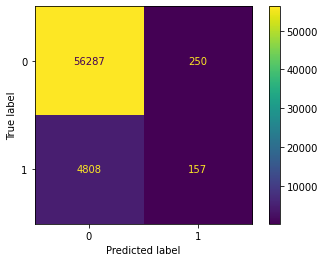

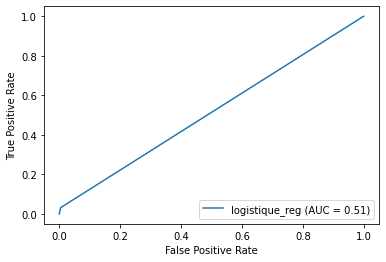

In [ ]:
test_model("logistique_reg",pipe_lr,X_sample,y_sample,X_test)

In [ ]:
rdm = RandomForestClassifier()

In [ ]:
pipe_rdm = make_pipeline(imp,scaler,acp,rdm )

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.92      1.00      0.00      0.96      0.02      0.00     56537
        1.0       0.03      0.00      1.00      0.00      0.02      0.00      4965

avg / total       0.85      0.92      0.08      0.88      0.02      0.00     61502



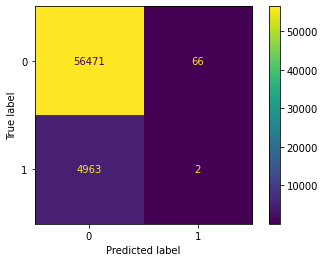

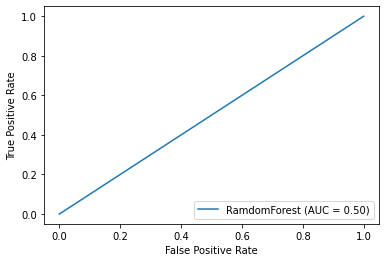

In [ ]:
test_model("RamdomForest",pipe_rdm,X_sample,y_sample,X_test)

In [ ]:
lgbm = LGBMClassifier()

In [ ]:
pipe_lgbm = make_pipeline(imp,scaler,acp,lgbm )

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.92      1.00      0.01      0.96      0.10      0.01     56537
        1.0       0.36      0.01      1.00      0.02      0.10      0.01      4965

avg / total       0.88      0.92      0.09      0.88      0.10      0.01     61502



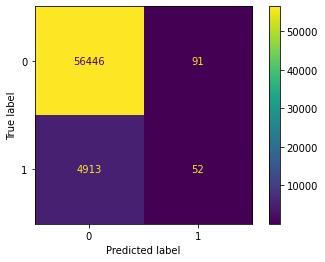

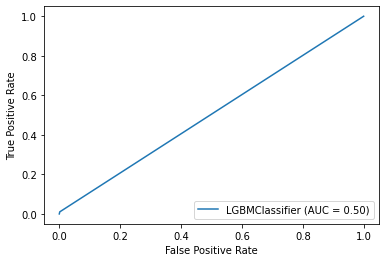

In [ ]:
test_model("LGBMClassifier",pipe_lgbm,X_sample,y_sample,X_test)

## Exploitation des methodes de gestion des data set déséquilibré

In [ ]:
pipe_lr = make_pipeline(lr)
pipe_rdm = make_pipeline(rdm)
pipe_lgbm = make_pipeline(lgbm)

In [ ]:
model_dict = {"LR": pipe_lr, 
              "rdm": pipe_rdm, 
              "lgbm": pipe_lgbm}

In [ ]:
model_dict

{'LR': Pipeline(steps=[('logisticregression', LogisticRegression())]),
 'lgbm': Pipeline(steps=[('lgbmclassifier', LGBMClassifier())]),
 'rdm': Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])}

In [ ]:
for i in model_dict.items():
  print(i[0])
  test_model(i[0],i[1],X_ro,y_ro,x_test_norm)

Pipeline(steps=[('pca', PCA(n_components=0.99)),
                ('logisticregression', LogisticRegression())])
Pipeline(steps=[('pca', PCA(n_components=0.99)),
                ('randomforestclassifier', RandomForestClassifier())])
Pipeline(steps=[('pca', PCA(n_components=0.99)),
                ('lgbmclassifier', LGBMClassifier())])


### Sur échantillonnage

In [ ]:
rOs = RandomOverSampler()
pipe_norm_lr = make_pipeline(imp,scaler,acp)
X_train_norm = pipe_norm_lr.fit_transform(X_sample)
x_test_norm = pipe_norm_lr.transform(X_test)
X_ro, y_ro = rOs.fit_resample(X_train_norm, y_sample)


In [ ]:
print ( ' Nb feature avant', y_sample.shape , 'nb feature apres' ,y_ro.shape)

 Nb feature avant (24600,) nb feature apres (45228,)


In [ ]:
print ( 'répartition ' , y_ro.value_counts(normalize=True) * 100 )

répartition  1.0    50.0
0.0    50.0
Name: TARGET, dtype: float64


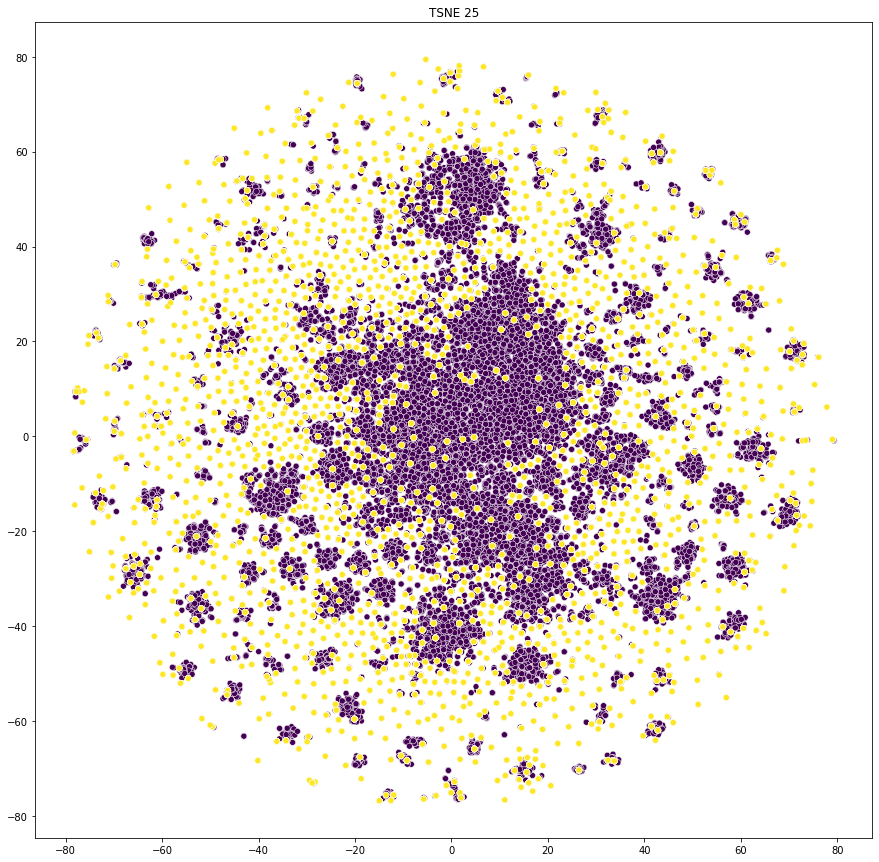

In [ ]:
tsne_25 = TSNE(perplexity = 25  , n_components = 2)
X_embedded_25 = tsne_25.fit_transform(X_ro)
fig = plt.figure(figsize=(15,15))
plt.title("TSNE 25")
sns.scatterplot(X_embedded_25[:,0], X_embedded_25[:,1], c=y_ro, legend='full')

LR


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.70      0.66      0.81      0.68      0.47     56537
        1.0       0.16      0.66      0.70      0.26      0.68      0.46      4965

avg / total       0.90      0.70      0.67      0.77      0.68      0.47     61502

rdm
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.92      1.00      0.00      0.96      0.00      0.00     56537
        1.0       0.00      0.00      1.00      0.00      0.00      0.00      4965

avg / total       0.85      0.92      0.08      0.88      0.00      0.00     61502

lgbm
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.94      0.91      0.29      0.92      0.52      0.28     56537
        1.0       0.22      0.29      0.91      0.25      0.52      0.25      4965

avg / total       0.88      0.86      0.34      0.87      0.52      0.

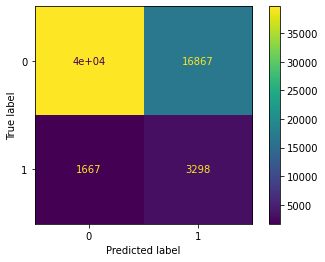

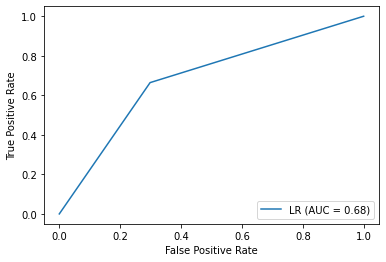

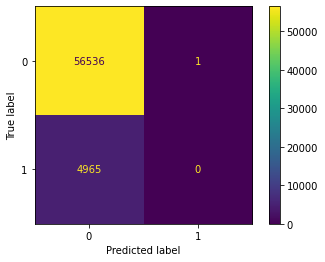

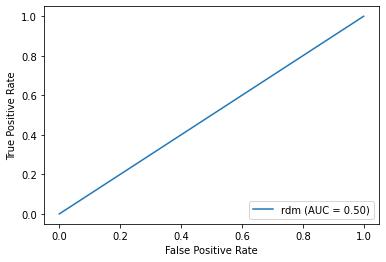

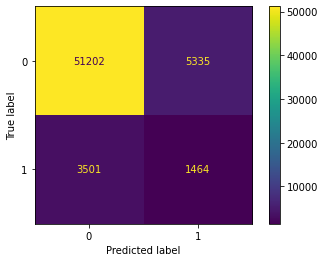

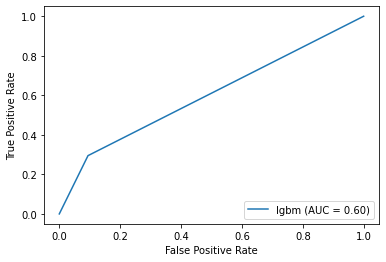

In [ ]:
for i in model_dict.items():
  print(i[0])
  test_model(i[0],i[1],X_ro,y_ro,x_test_norm)

### Sous échantillonnage

In [ ]:
rUs = RandomUnderSampler()

In [ ]:
pipe_norm_lr = make_pipeline(imp,scaler,acp)
X_train_norm = pipe_norm_lr.fit_transform(X_sample)
X_test_norm = pipe_norm_lr.transform(X_test)
X_ru, y_ru = rUs.fit_resample(X_train_norm, y_sample)

In [ ]:
print ( ' Nb feature avant', y_sample.shape , 'nb feature apres' ,y_ru.shape)

 Nb feature avant (24600,) nb feature apres (3972,)


In [ ]:
print ( 'répartition ' , y_ru.value_counts(normalize=True) * 100 )

répartition  1.0    50.0
0.0    50.0
Name: TARGET, dtype: float64


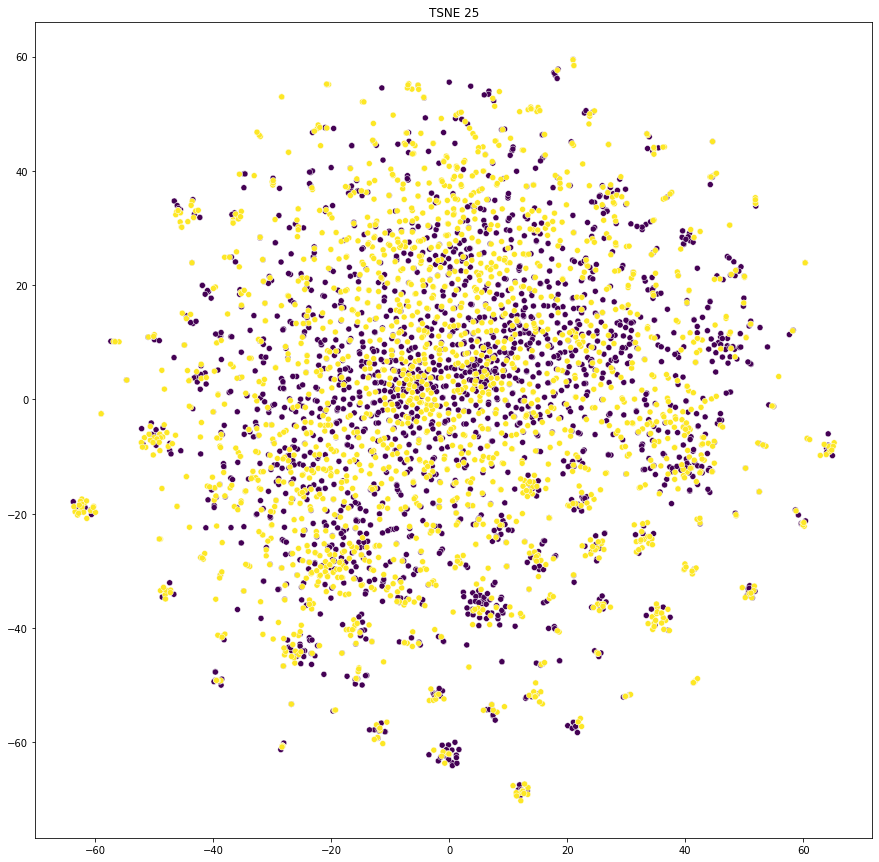

In [ ]:
tsne_25 = TSNE(perplexity = 25  , n_components = 2)
X_embedded_25 = tsne_25.fit_transform(X_ru)
fig = plt.figure(figsize=(15,15))
plt.title("TSNE 25")
sns.scatterplot(X_embedded_25[:,0], X_embedded_25[:,1], c=y_ru, legend='full')

LR


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.66      0.67      0.78      0.67      0.44     56537
        1.0       0.15      0.67      0.66      0.24      0.67      0.44      4965

avg / total       0.89      0.66      0.67      0.74      0.67      0.44     61502

rdm
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.62      0.61      0.75      0.61      0.38     56537
        1.0       0.12      0.61      0.62      0.20      0.61      0.38      4965

avg / total       0.88      0.62      0.61      0.70      0.61      0.38     61502

lgbm
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.64      0.65      0.76      0.64      0.41     56537
        1.0       0.14      0.65      0.64      0.22      0.64      0.41      4965

avg / total       0.89      0.64      0.65      0.72      0.64      0.

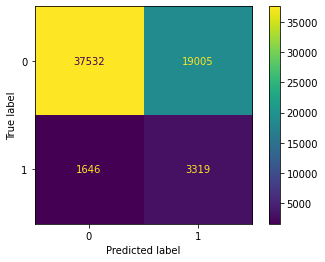

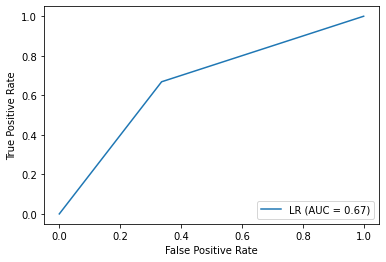

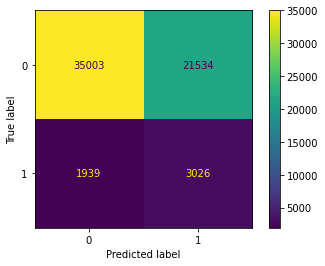

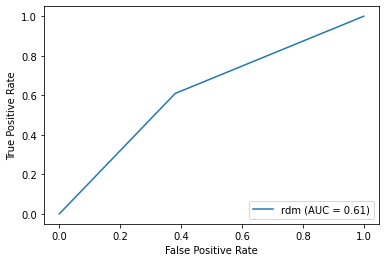

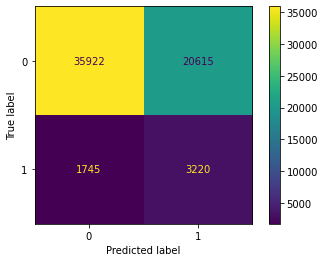

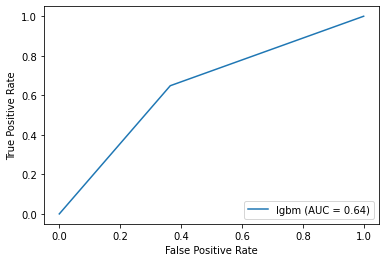

In [ ]:
for i in model_dict.items():
  print(i[0])
  test_model(i[0],i[1],X_ru,y_ru,x_test_norm)

### SMOT

In [ ]:
smo = SMOTE()

In [ ]:
pipe_norm_lr = make_pipeline(imp,scaler,acp)
X_train_norm = pipe_norm_lr.fit_transform(X_sample)
X_test_norm = pipe_norm_lr.transform(X_test)
X_sm, y_sm = smo.fit_resample(X_train_norm, y_sample)

In [ ]:
print ( ' Nb feature avant', y_sample.shape , 'nb feature apres' ,y_sm.shape)

 Nb feature avant (24600,) nb feature apres (45228,)


In [ ]:
y_sm.value_counts(normalize=True) * 100

1.0    50.0
0.0    50.0
Name: TARGET, dtype: float64

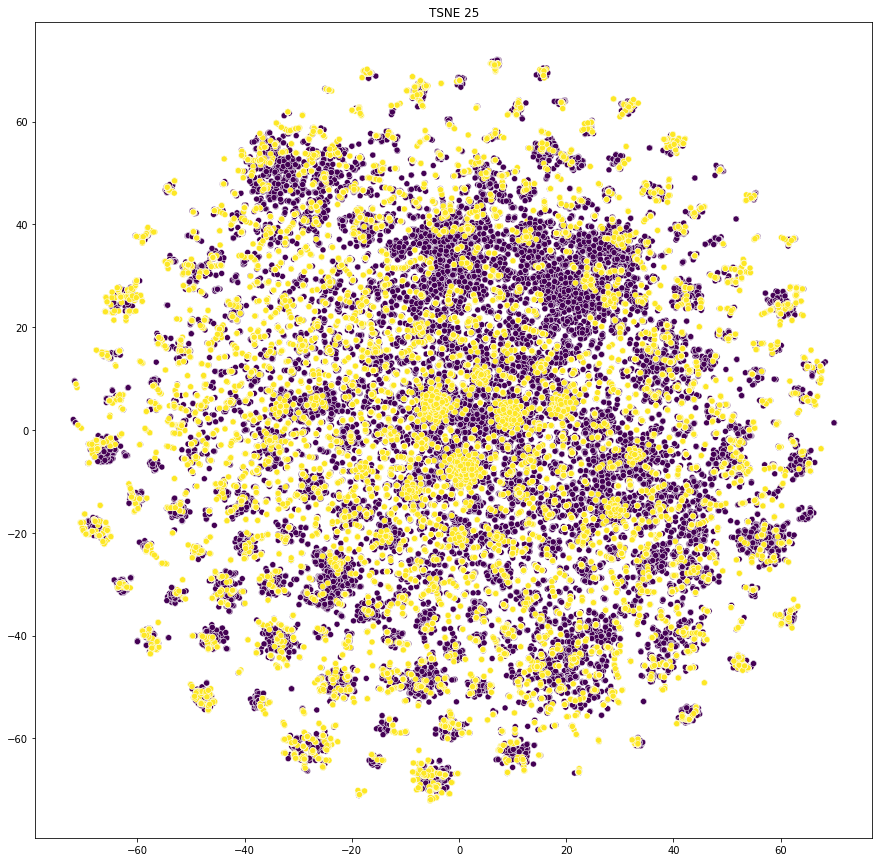

In [ ]:
tsne_25 = TSNE(perplexity = 25  , n_components = 2)
X_embedded_25 = tsne_25.fit_transform(X_sm)
fig = plt.figure(figsize=(15,15))
plt.title("TSNE 25")
sns.scatterplot(X_embedded_25[:,0], X_embedded_25[:,1], c=y_sm, legend='full')

LR


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.73      0.61      0.83      0.67      0.45     56537
        1.0       0.16      0.61      0.73      0.26      0.67      0.44      4965

avg / total       0.89      0.72      0.62      0.78      0.67      0.45     61502

rdm
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.92      0.98      0.04      0.95      0.20      0.04     56537
        1.0       0.18      0.04      0.98      0.06      0.20      0.03      4965

avg / total       0.86      0.91      0.12      0.88      0.20      0.04     61502

lgbm
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.93      0.90      0.26      0.92      0.48      0.25     56537
        1.0       0.18      0.26      0.90      0.21      0.48      0.22      4965

avg / total       0.87      0.85      0.31      0.86      0.48      0.

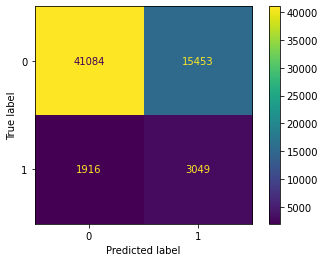

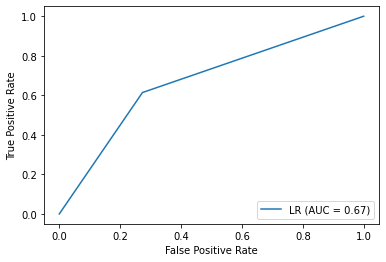

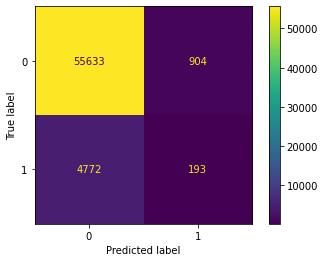

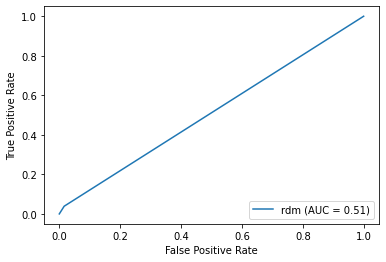

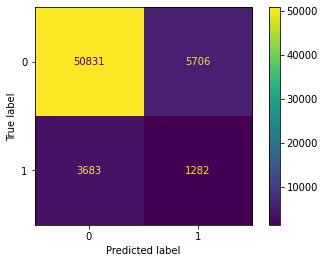

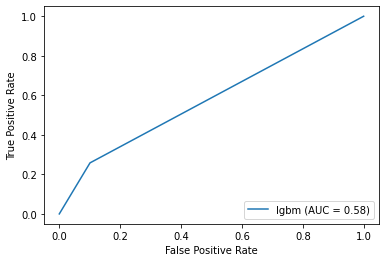

In [ ]:
for i in model_dict.items():
  print(i[0])
  test_model(i[0],i[1],X_sm,y_sm,x_test_norm)

# Optimisation lgbm

In [ ]:
param = {'num_leaves': 100, 'objective': 'binary'}
param['metric'] = ['auc', 'binary_logloss']

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
gbm = lgb.train(param,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.522947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60041
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 535
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.773587	valid_0's binary_logloss: 0.24211


In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

<function matplotlib.pyplot.show>

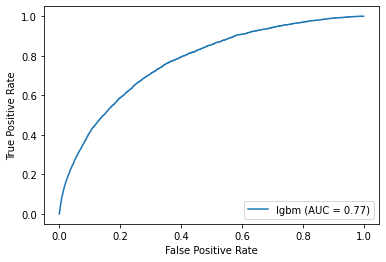

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name="lgbm")
display.plot()
plt.show

## test avec smot

In [ ]:
pipe_norm_lr = make_pipeline(imp,scaler)
X_train_norm = pipe_norm_lr.fit_transform(X_train)
X_test_norm = pipe_norm_lr.transform(X_test)
X_sm, y_sm = smo.fit_resample(X_train_norm, y_train)

In [ ]:
lgb_train = lgb.Dataset(X_sm, y_sm)
lgb_eval = lgb.Dataset(X_test_norm, y_test, reference=lgb_train)

In [ ]:
gbm = lgb.train(param,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[1]	valid_0's binary_logloss: 0.652418	valid_0's auc: 0.667453
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.616442	valid_0's auc: 0.668324
[3]	valid_0's binary_logloss: 0.587746	valid_0's auc: 0.677809
[4]	valid_0's binary_logloss: 0.559562	valid_0's auc: 0.679964
[5]	valid_0's binary_logloss: 0.534137	valid_0's auc: 0.683093
[6]	valid_0's binary_logloss: 0.510152	valid_0's auc: 0.684731
[7]	valid_0's binary_logloss: 0.492187	valid_0's auc: 0.685073
[8]	valid_0's binary_logloss: 0.472833	valid_0's auc: 0.689049
[9]	valid_0's binary_logloss: 0.454714	valid_0's auc: 0.691123
[10]	valid_0's binary_logloss: 0.441724	valid_0's auc: 0.692862
[11]	valid_0's binary_logloss: 0.42813	valid_0's auc: 0.691587
[12]	valid_0's binary_logloss: 0.412855	valid_0's auc: 0.693127
[13]	valid_0's binary_logloss: 0.399278	valid_0's auc: 0.695826
[14]	valid_0's binary_logloss: 0.387758	valid_0's auc: 0.697329
[15]	valid_0's binary_logloss: 0.377951	valid_0's auc

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

<function matplotlib.pyplot.show>

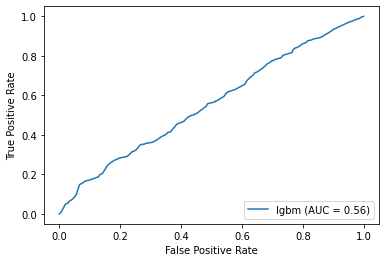

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name="lgbm")
display.plot()
plt.show

## test avec oversampler

In [ ]:
rOs = RandomOverSampler()
pipe_norm_lr = make_pipeline(imp,scaler)
X_train_norm = pipe_norm_lr.fit_transform(X_train)
X_test_norm = pipe_norm_lr.transform(X_test)
X_sm, y_sm = rOs.fit_resample(X_train_norm, y_train)

In [ ]:
lgb_train = lgb.Dataset(X_sm, y_sm)
lgb_eval = lgb.Dataset(X_test_norm, y_test, reference=lgb_train)

In [ ]:
gbm = lgb.train(param,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[1]	valid_0's binary_logloss: 0.679468	valid_0's auc: 0.719902
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.668264	valid_0's auc: 0.724839
[3]	valid_0's binary_logloss: 0.658701	valid_0's auc: 0.728264
[4]	valid_0's binary_logloss: 0.650519	valid_0's auc: 0.73105
[5]	valid_0's binary_logloss: 0.643674	valid_0's auc: 0.733189
[6]	valid_0's binary_logloss: 0.637697	valid_0's auc: 0.735023
[7]	valid_0's binary_logloss: 0.632195	valid_0's auc: 0.737231
[8]	valid_0's binary_logloss: 0.627631	valid_0's auc: 0.738717
[9]	valid_0's binary_logloss: 0.623458	valid_0's auc: 0.740184
[10]	valid_0's binary_logloss: 0.619725	valid_0's auc: 0.741785
[11]	valid_0's binary_logloss: 0.616281	valid_0's auc: 0.743313
[12]	valid_0's binary_logloss: 0.612939	valid_0's auc: 0.745454
[13]	valid_0's binary_logloss: 0.610163	valid_0's auc: 0.746835
[14]	valid_0's binary_logloss: 0.607547	valid_0's auc: 0.74794
[15]	valid_0's binary_logloss: 0.605093	valid_0's auc:

In [ ]:
y_pred = gbm.predict(X_test_norm, num_iteration=gbm.best_iteration)

<function matplotlib.pyplot.show>

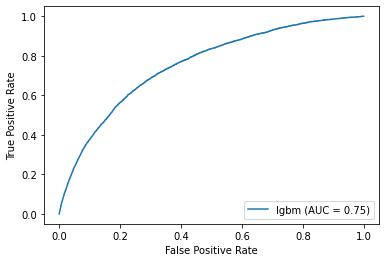

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name="lgbm")
display.plot()
plt.show

## test avec undersampler

In [ ]:
rUs = RandomUnderSampler()
pipe_norm_lr = make_pipeline(imp,scaler)
X_train_norm = pipe_norm_lr.fit_transform(X_train)
X_test_norm = pipe_norm_lr.transform(X_test)
X_sm, y_sm = rUs.fit_resample(X_train_norm, y_train)

In [ ]:
lgb_train = lgb.Dataset(X_sm, y_sm)
lgb_eval = lgb.Dataset(X_test_norm, y_test, reference=lgb_train)

In [ ]:
gbm = lgb.train(param,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[1]	valid_0's binary_logloss: 0.679645	valid_0's auc: 0.719387
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.668369	valid_0's auc: 0.726083
[3]	valid_0's binary_logloss: 0.659364	valid_0's auc: 0.727345
[4]	valid_0's binary_logloss: 0.651697	valid_0's auc: 0.730767
[5]	valid_0's binary_logloss: 0.645194	valid_0's auc: 0.732727
[6]	valid_0's binary_logloss: 0.639459	valid_0's auc: 0.734832
[7]	valid_0's binary_logloss: 0.634382	valid_0's auc: 0.736581
[8]	valid_0's binary_logloss: 0.630308	valid_0's auc: 0.737742
[9]	valid_0's binary_logloss: 0.626369	valid_0's auc: 0.73873
[10]	valid_0's binary_logloss: 0.62327	valid_0's auc: 0.739965
[11]	valid_0's binary_logloss: 0.620122	valid_0's auc: 0.742054
[12]	valid_0's binary_logloss: 0.617421	valid_0's auc: 0.744174
[13]	valid_0's binary_logloss: 0.614741	valid_0's auc: 0.745667
[14]	valid_0's binary_logloss: 0.612341	valid_0's auc: 0.747099
[15]	valid_0's binary_logloss: 0.610064	valid_0's auc:

In [ ]:
y_pred = gbm.predict(X_test_norm, num_iteration=gbm.best_iteration)

<function matplotlib.pyplot.show>

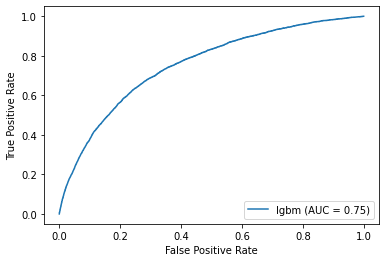

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name="lgbm")
display.plot()
plt.show

Finalement les resultat de lgbm "brut" sont identique aux meilleurs resultat avec sampler , nous allons donc optimiser lgbm sans traitement particulier des données du train set

## Optimlisation des hyperparametres de lgbm

Fonction de recherche des meilleurs hyperparametre utilisant un mode random

https://medium.com/@sergei740/hyperparameter-tuning-lightgbm-using-random-grid-search-dc11c2f8c805

In [ ]:
y_train = train["TARGET"]
X_train = train.drop(["TARGET"],axis=1)
y_test = test["TARGET"]
X_test = test.drop(["TARGET"],axis=1)

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
max = 0.0 #Set the minimum auc arbitrarily 
count = 0 #Used for keeping track of the iteration number
iterations = 50 # number of itération

for i in range(iterations):
    print('iteration number', count)
    count += 1 #increment count
    try:
        d_train = lgb.Dataset(X_train, y_train) #Load in data
        params = {} #initialize parameters
        params['objective'] = 'binary'
        params['metric'] = 'auc'
        params['boosting_type'] = np.random.choice(['gbdt', 'dart', 'goss'])
        params['sub_feature'] = np.random.uniform(0, 1)
        params['num_leaves'] = np.random.randint(20, 300)
        params['min_data'] = np.random.randint(10, 100)
        params['max_depth'] = np.random.randint(5, 200)
        params['is_unbalance'] = np.random.choice(['true', 'false'])
        iterations = np.random.randint(10, 50)
        print(params, iterations)
        clf = lgb.train(params, d_train, iterations)
        print('max:', max)
        y_pred=clf.predict(X_test) #Create predictions on test set
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        auc = metrics.auc(fpr, tpr)
        print('auc:', auc)
        if auc > max:
          max = auc
          pp = params 
    except: #in case something goes wrong
        print('failed with')
        print(params)
print("*" * 50)
print('max auc is: ', max)
print('Used params', pp)

iteration number 0
{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'goss', 'sub_feature': 0.07257629787523345, 'num_leaves': 62, 'min_data': 59, 'max_depth': 88, 'is_unbalance': 'false'} 18
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.279244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60027
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 528
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
max: 0.0
auc: 0.7346963135353564
iteration number 1
{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'sub_feature': 0.9375796505988219, 'num_leaves': 253, 'min_data': 59, 'max_depth': 139, 

max auc is:  0.7713470851134195

Used params {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'sub_feature': 0.8586060173113411, 'num_leaves': 112, 'min_data': 45, 'max_depth': 145, 'is_unbalance': 'true'}

In [ ]:
param = {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'sub_feature': 0.8586060173113411, 'num_leaves': 112, 'min_data': 45, 'max_depth': 145, 'is_unbalance': 'true'}

In [ ]:
gbm = lgb.train(param,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.868215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60041
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 535
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.772626


In [ ]:
joblib.dump(gbm, '/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/gbm.joblib')

['/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/gbm.joblib']

In [6]:
model =  joblib.load('/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/gbm.joblib')

In [7]:
filename = '/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/gbm.sav'

In [8]:
pickle.dump(model, open(filename, 'wb'))

In [9]:
loaded_model = pickle.load(open(filename, 'rb'))

In [10]:
data = pd.read_pickle("/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/df_data_dash.pkl")

In [ ]:
y_pred = model.predict(X_test)

<function matplotlib.pyplot.show>

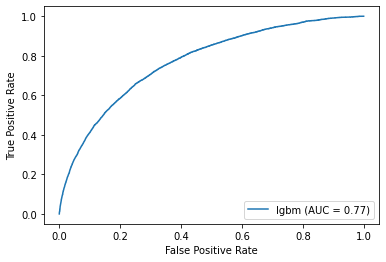

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name="lgbm")
display.plot()
plt.show

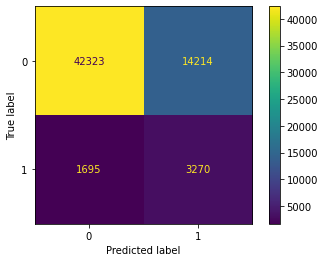

In [ ]:
threshold = 0.5
y_pred = (model.predict(X_test) > threshold).astype('float')
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

# Analyse shape

In [ ]:
pip install shap

     |████████████████████████████████| 564 kB 13.1 MB/s 


In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


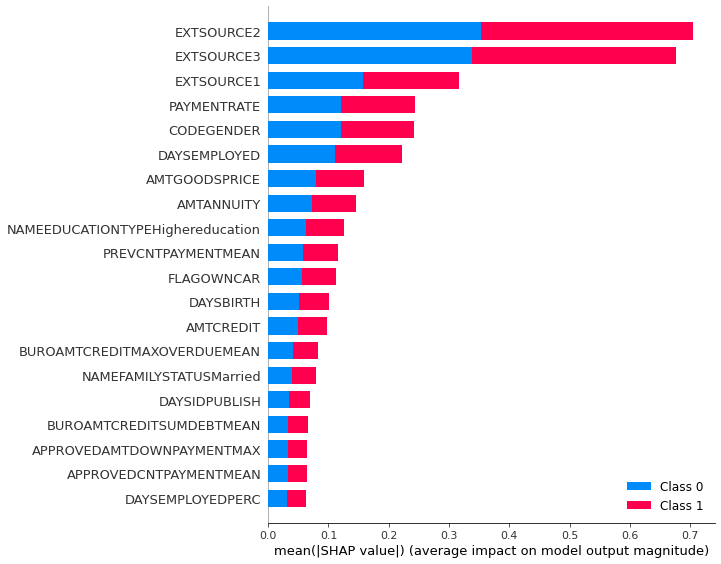

In [ ]:
shap.summary_plot(shap_values, X_test)

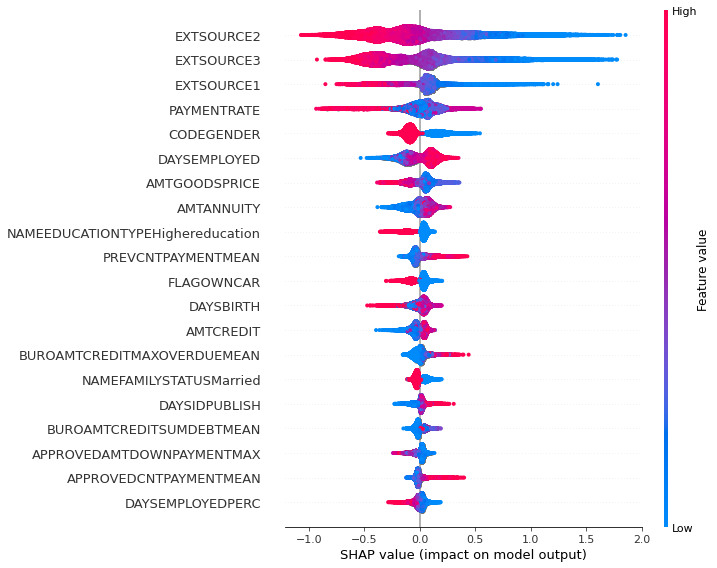

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values[1], X_test)
f.savefig("/content/drive/MyDrive/Openclassrooms/P7 scoring/git_collab_P7/git_collab_P7/dashboard/summary_plot1.png", bbox_inches='tight', dpi=600)